In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [3]:
rf_wrf = xr.open_dataset("/Users/dgagne/data/wrf_ml_surface/rf6/wrfout_d01_1999-10-22_19:00:00")
most_wrf = xr.open_dataset("/Users/dgagne/data/wrf_ml_surface/most/wrfout_d01_1999-10-22_19:00:00")

In [3]:
rf_wrf["FLQC"]

<xarray.DataArray 'FLQC' (Time: 355, south_north: 2, west_east: 2)>
array([[[ 0.      ,  0.      ],
        [ 0.      ,  0.      ]],

       [[ 0.009971,  0.009971],
        [ 0.009971,  0.009971]],

       ...,

       [[-0.013324, -0.013324],
        [-0.013324, -0.013324]],

       [[-0.013479, -0.013479],
        [-0.013479, -0.013479]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  SURFACE EXCHANGE COEFFICIENT FOR MOISTURE
    units:        
    stagger:      

(59, 355)
(59, 355)
(59, 355)
(59, 355)


/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


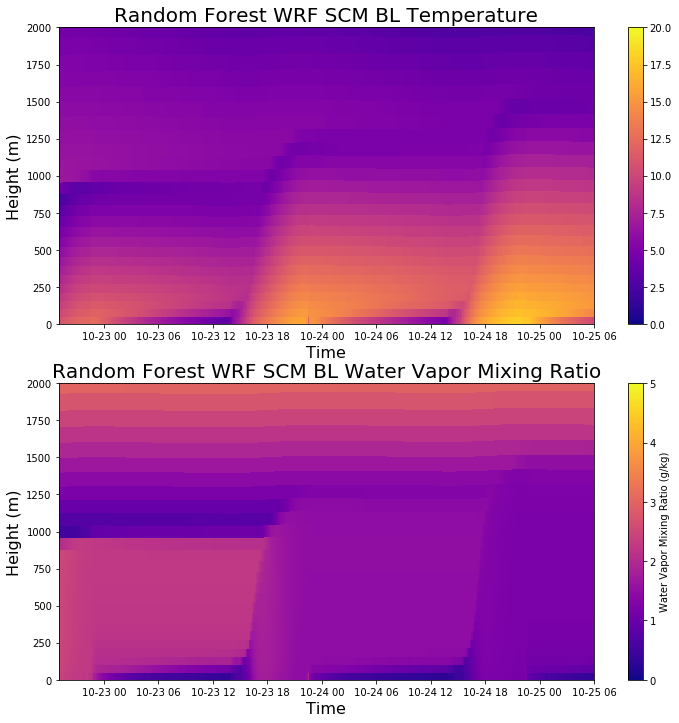

In [4]:
plt.figure(figsize=(12, 12))
pres = (rf_wrf["P"][:, :, 0, 0].T  +rf_wrf["PB"][:, :, 0, 0].T)
height = (rf_wrf["PH"][:, :-1, 0, 0].T + rf_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((rf_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = rf_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(rf_wrf["U"][:, :, 0, 0].T ** 2 + rf_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Temperature", fontsize=20)
plt.colorbar()
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=5, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("rf_wrf_temp_moisture.png", dpi=200, bbox_inches="tight")

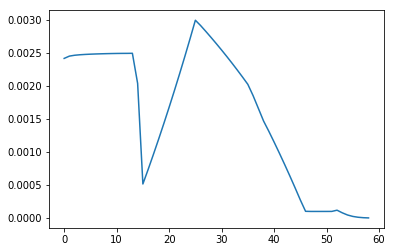

In [4]:
plt.plot(rf_wrf["QVAPOR"][1, :, 0, 0])

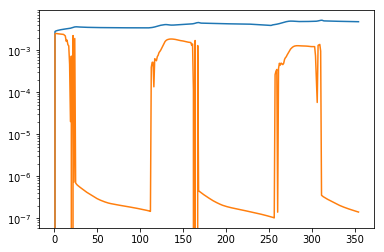

In [5]:
plt.plot(most_wrf["Q2"][:, 0, 0])
plt.plot(rf_wrf["Q2"][:, 0, 0])

plt.gca().set_yscale("log")

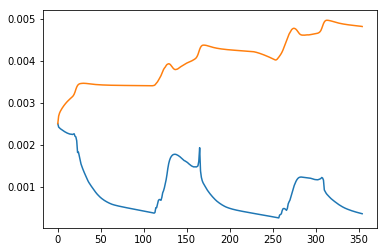

In [6]:
plt.plot(rf_wrf["QVAPOR"][:, 0, 0, 0])
plt.plot(most_wrf["QVAPOR"][:, 0, 0, 0])

(-10, 20)

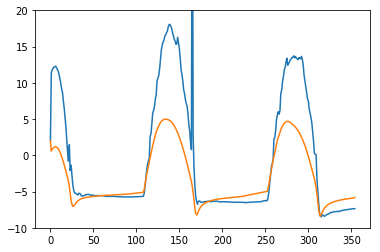

In [7]:
plt.plot(rf_wrf["TSK"][:, 0, 0] - (rf_wrf["T"][:, 0, 0, 0] + 300))
plt.plot(most_wrf["TSK"][:, 0, 0] - (most_wrf["T"][:, 0, 0, 0] + 300))
plt.ylim(-10, 20)

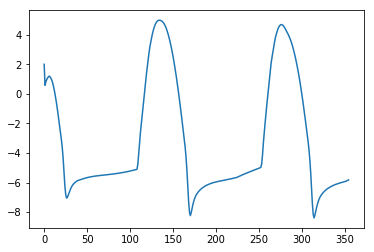

In [17]:
plt.plot(most_wrf["TSK"][:, 0, 0] - (most_wrf["T"][:, 0, 0, 0] + 300))

In [23]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))
def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

saturation_mixing_ratio(most_wrf["TSK"][5, 0, 0], most_wrf["PSFC"][5, 0, 0] / 100) / 1000


<xarray.DataArray ()>
array(0.010981)
Coordinates:
    XLAT     float32 37.6
    XLONG    float32 -96.7
    XTIME    datetime64[ns] 1999-10-22T19:50:00

In [21]:
most_wrf["PSFC"]

<xarray.DataArray 'PSFC' (Time: 355, south_north: 2, west_east: 2)>
array([[[    0.  ,     0.  ],
        [    0.  ,     0.  ]],

       [[97123.65, 97123.65],
        [97123.65, 97123.65]],

       ...,

       [[97153.19, 97153.19],
        [97153.19, 97153.19]],

       [[97153.19, 97153.19],
        [97153.19, 97153.19]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
    XTIME    (Time) datetime64[ns] ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  SFC PRESSURE
    units:        Pa
    stagger:      

(59, 355)
(59, 355)
(59, 355)
(59, 355)


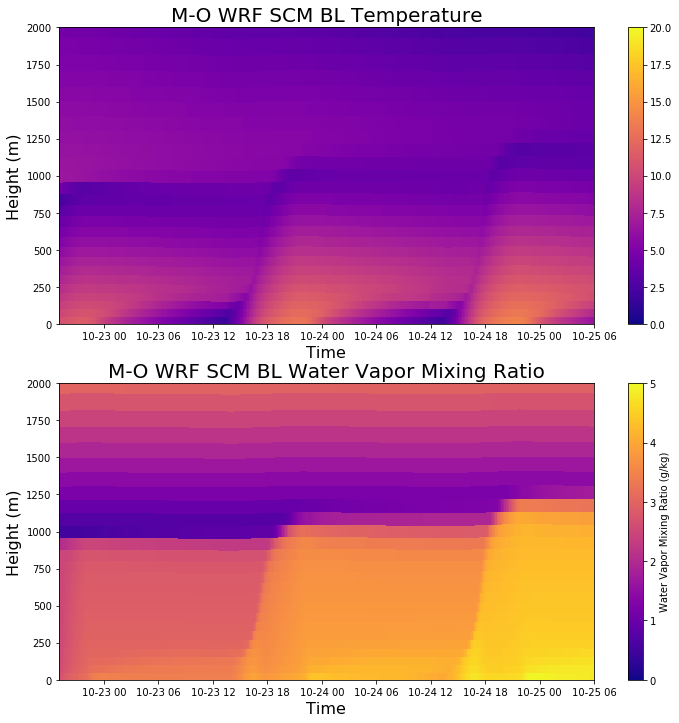

In [4]:
plt.figure(figsize=(12, 12))
pres = (most_wrf["P"][:, :, 0, 0].T  +most_wrf["PB"][:, :, 0, 0].T)
height = (most_wrf["PH"][:, :-1, 0, 0].T + most_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((most_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = most_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(most_wrf["U"][:, :, 0, 0].T ** 2 + most_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Temperature", fontsize=20)
plt.colorbar()
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=5, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("most_wrf_temp_moisture.png", dpi=200, bbox_inches="tight")


(0, 0.003)

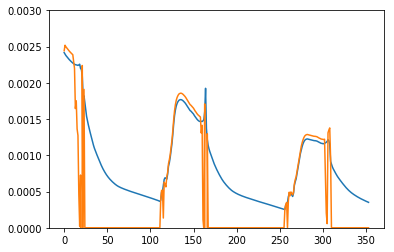

In [7]:
plt.plot(rf_wrf["QVAPOR"][1:, 0, 0, 0].T)
plt.plot(rf_wrf["Q2"][1:, 0, 0].T)
plt.ylim(0, 0.003)

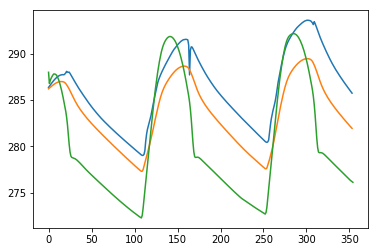

In [43]:
plt.plot(rf_wrf["T"][1:, 0, 0, 0] + 300)
plt.plot(most_wrf["T"][1:, 0, 0, 0] + 300)

#plt.plot(rf_wrf["TH2"][1:,0, 0])
#plt.plot(rf_wrf["T2"][1:, 0, 0])
#plt.plot(rf_wrf["TSK"][0:, 0, 0])
plt.plot(most_wrf["TSK"][0:, 0, 0])


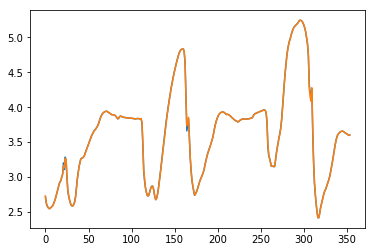

In [11]:
plt.plot(rf_wrf["U"][1:, 0, 0, 0])
plt.plot(rf_wrf["U10"][1:, 0, 0])

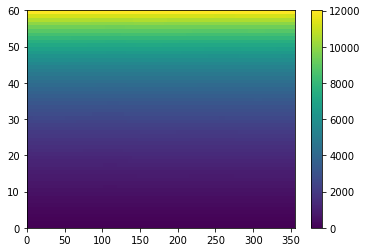

In [6]:
plt.pcolormesh((rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81)
plt.colorbar()

(200, 310)

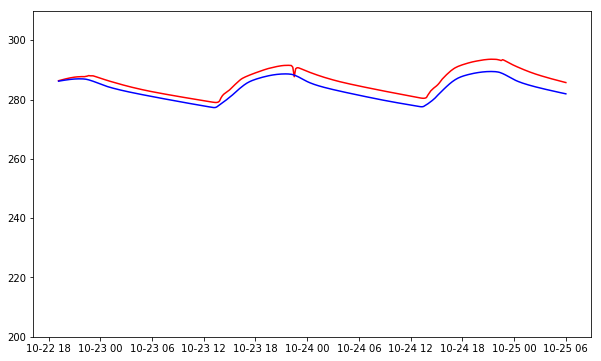

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["T"][1:, 0, 0, 0] + 300, 'r-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["T"][1:, 0, 0, 0] + 300, 'b-')
plt.ylim(200, 310)

(0, 5)

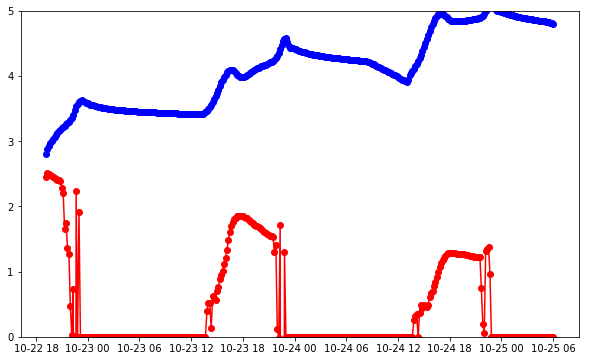

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["Q2"][1:, 0, 0] * 1000, 'ro-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["Q2"][1:, 0, 0] * 1000, 'bo-')
plt.ylim(0, 5)

(730049.7986111111, 730052.25)

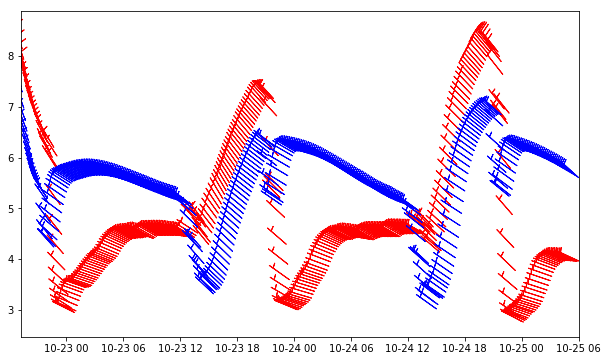

In [22]:
rf_wspd = np.sqrt(rf_wrf["U"][1:, 0, 0, 0] ** 2 + rf_wrf["V"][1:, 0, 0, 0] ** 2)
most_wspd = np.sqrt(most_wrf["U"][1:, 0, 0, 0] ** 2 + most_wrf["V"][1:, 0, 0, 0] ** 2)
times = pd.DatetimeIndex(most_wrf["XTIME"].values[1:])
plt.figure(figsize=(10, 6))
plt.barbs(times, rf_wspd, 
          rf_wrf["U10"][1:, 0, 0], rf_wrf["V10"][1:, 0, 0], color='r')
plt.barbs(times, most_wspd, 
          most_wrf["U10"][1:, 0, 0], most_wrf["V10"][1:, 0, 0], color='b')
plt.xlim(times.min(), times.max())

In [44]:
precip = xr.open_dataset("http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/cpc_us_precip/RT/precip.V1.0.2018.nc")

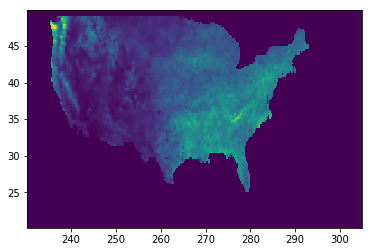

In [49]:
plt.pcolormesh(precip["lon"], precip["lat"], precip["precip"].sum(axis=0))

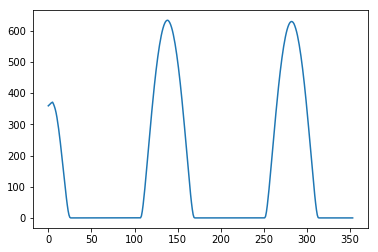

In [134]:
plt.plot(rf_wrf["SWDOWN"][1:, 0, 0])

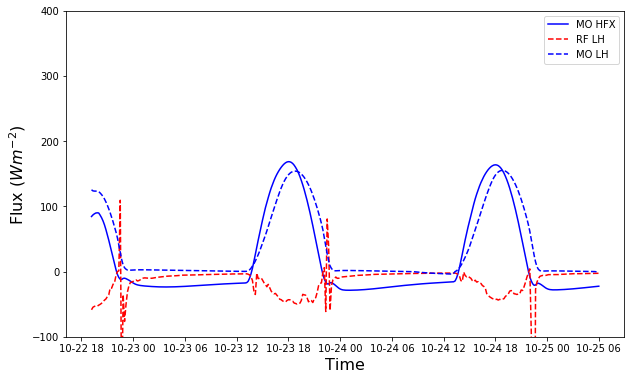

In [27]:
plt.figure(figsize=(10, 6))
#plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp.png", dpi=200, bbox_inches="tight")

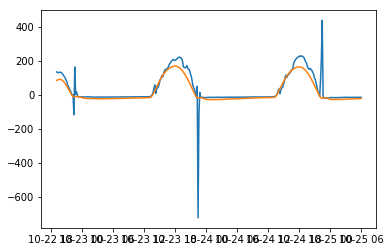

In [9]:
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0])
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0])

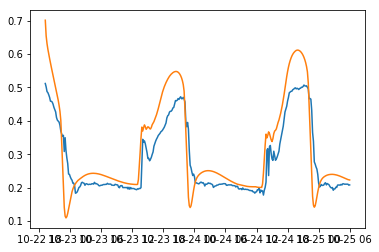

In [19]:
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["UST"][1:, 0, 0])
plt.plot(most_wrf["XTIME"][1:], most_wrf["UST"][1:, 0, 0])

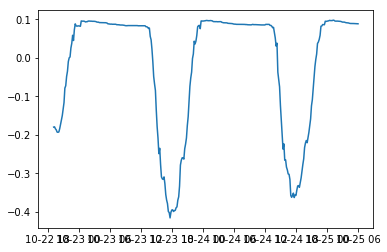

In [7]:
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["MOL"][1:, 0, 0])


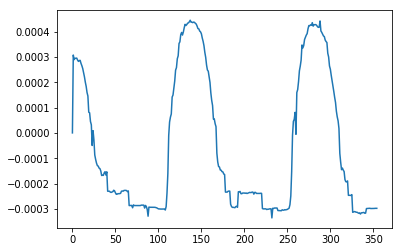

In [8]:
plt.plot(rf_wrf["QSTAR"][:, 0, 0])

(array([  0.,   4.,   0.,   0.,   4.,   0.,   0.,   4.,   8.,  28.,  52.,
         92.,  56.,  52.,  36.,  36.,  68., 100., 284., 556.,  12.,   4.,
          0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   4.,   0.,   0.]),
 array([-100,  -95,  -90,  -85,  -80,  -75,  -70,  -65,  -60,  -55,  -50,
         -45,  -40,  -35,  -30,  -25,  -20,  -15,  -10,   -5,    0,    5,
          10,   15,   20,   25,   30,   35,   40,   45,   50,   55,   60,
          65,   70,   75,   80,   85,   90,   95]),
 <a list of 39 Patch objects>)

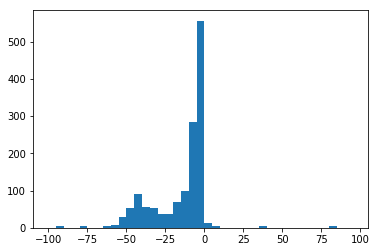

In [35]:
plt.hist(rf_wrf["LH"].values.ravel(), np.arange(-100, 100, 5))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.,  36.,  24.,
         28., 352., 248., 136.,  12.,   4.,   8.,   4.,   4.,   8.,   4.,
          4.,   4.,   4.,   0.,   4.,   0.,   8.,   4.,   4.,   0.,   4.,
          4.,   0.,   0.,   0.,   8.,   4.,   4.,   4.,   0.,   0.,   4.,
          4.,   0.,   0.,   0.,   4.,   8.,   0.,   4.,   4.,   0.,   0.,
          4.,   4.,   0.,   0.,   0., 

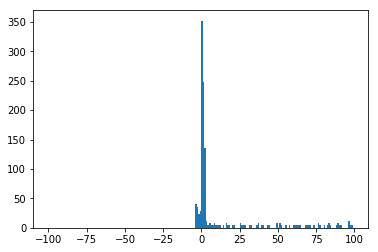

In [36]:
plt.hist(most_wrf["LH"].values.ravel(), np.arange(-100, 100))

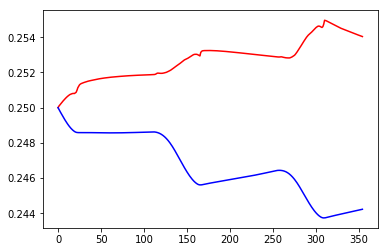

In [5]:
plt.plot(rf_wrf["SMOIS"][:, 0, 0, 0], color='r')
plt.plot(most_wrf["SMOIS"][:, 0, 0, 0], color='b')

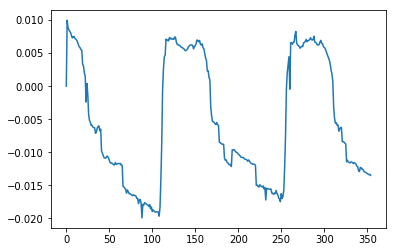

In [15]:
#plt.plot(rf_wrf["FLHC"][:, 0, 0])
plt.plot(rf_wrf["FLQC"][:, 0, 0])

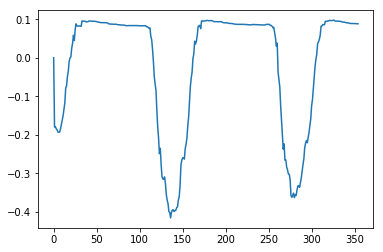

In [9]:
plt.plot(rf_wrf["MOL"][:, 0, 0])


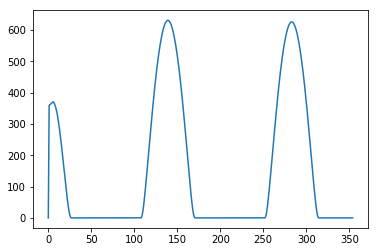

In [16]:
plt.plot(rf_wrf["SWDOWN"][:, 0, 0])


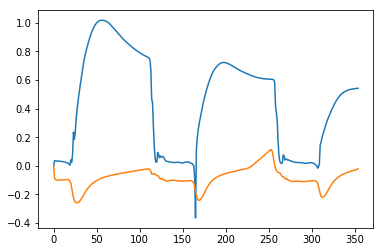

In [38]:
moist_rf =  rf_wrf["QVAPOR"][:, :, 0, 0].T * 1000
moist_mo = most_wrf["QVAPOR"][:, :, 0, 0].T * 1000
plt.plot(moist_rf[1] - moist_rf[0])
plt.plot(moist_mo[1] - moist_mo[0])

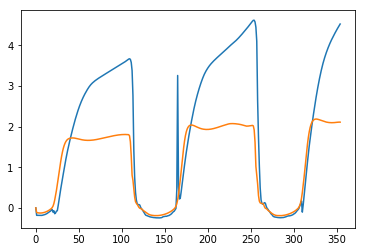

In [39]:
moist_rf =  rf_wrf["T"][:, :, 0, 0].T 
moist_mo = most_wrf["T"][:, :, 0, 0].T
plt.plot(moist_rf[1] - moist_rf[0])
plt.plot(moist_mo[1] - moist_mo[0])